<a href="https://colab.research.google.com/github/NxrFesdac/bourbaki-nlp-avanzado/blob/main/modulo1/TF_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install wordcloud

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# https://huggingface.co/datasets/nyu-mll/glue/tree/main/cola
df = pd.read_parquet('https://huggingface.co/datasets/nyu-mll/glue/resolve/main/cola/train-00000-of-00001.parquet')

print("First 5 rows of the DataFrame:")
print(df.head())

print("\nColumn names of the DataFrame:")
print(df.columns)

First 5 rows of the DataFrame:
                                            sentence  label  idx
0  Our friends won't buy this analysis, let alone...      1    0
1  One more pseudo generalization and I'm giving up.      1    1
2   One more pseudo generalization or I'm giving up.      1    2
3     The more we study verbs, the crazier they get.      1    3
4          Day by day the facts are getting murkier.      1    4

Column names of the DataFrame:
Index(['sentence', 'label', 'idx'], dtype='object')


In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet') #Lematización
nltk.download('omw-1.4') #Lematización
nltk.download('punkt_tab') #Word Cloud

print("NLTK stopwords and wordnet downloaded.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


NLTK stopwords and wordnet downloaded.


[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Identify text and target columns
text_column = 'sentence'
target_column = 'label'

# Initialize NLTK components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and special characters
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    return ' '.join(tokens)

# Apply preprocessing to the text column
df['preprocessed_sentence'] = df[text_column].apply(preprocess_text)

# Split data into training and testing sets
X = df['preprocessed_sentence']
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (6840,)
Testing data shape: (1711,)


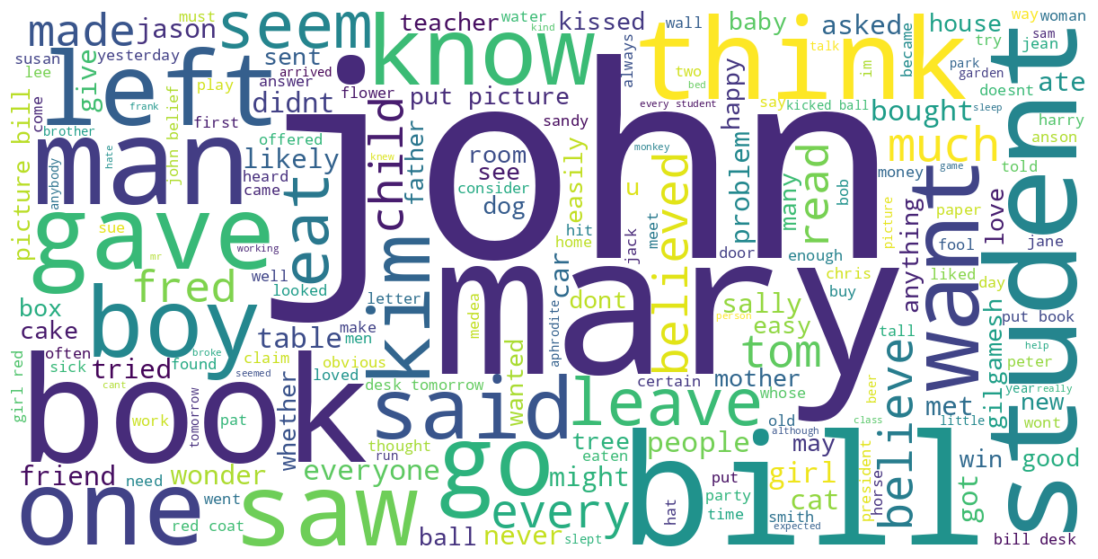

In [5]:
# --- WORD CLOUD (use training set to avoid test leakage) ---
text_for_wc = " ".join(X_train.dropna().astype(str))

wc = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    max_words=200
).generate(text_for_wc)

plt.figure(figsize=(16, 7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [6]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data and transform both training and testing data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF transformed training data shape: {X_train_tfidf.shape}")
print(f"TF-IDF transformed testing data shape: {X_test_tfidf.shape}")

TF-IDF transformed training data shape: (6840, 4424)
TF-IDF transformed testing data shape: (1711, 4424)


In [7]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# L2 norm is by default
model = LogisticRegression(random_state=42)

# Train the model
model.fit(X_train_tfidf, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Make predictions on the test set
y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.70
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.06      0.10       506
           1       0.71      0.97      0.82      1205

    accuracy                           0.70      1711
   macro avg       0.56      0.51      0.46      1711
weighted avg       0.62      0.70      0.61      1711


Confusion Matrix:
[[  28  478]
 [  40 1165]]


In [9]:
import getpass
from openai import OpenAI

openai_key = getpass.getpass()

client = OpenAI(api_key=openai_key)

··········


In [10]:
system_msg = """
Eres un evaluador de aceptabilidad gramatical.
Vas a recibir EXACTAMENTE 10 oraciones en inglés.

Para cada oración, decide si es gramaticalmente aceptable:
- 1 = aceptable / gramatical
- 0 = no aceptable / agramatical

Criterios:
- Evalúa SOLO gramática/sintaxis (orden de palabras, concordancia, tiempos verbales, subcategorización, preposiciones, etc.).
- Ignora si el significado es raro, inverosímil o “sin sentido”.
- Acepta variación común (US/UK). Errores claros => 0.
- Si no estás seguro, elige 0.

Salida:
Devuelve SOLO un JSON que cumpla el esquema solicitado (sin texto extra, sin explicación).
"""

In [11]:
import json

# Tomar las primeras 10 de X_test (por índice) y obtener el texto original
idx10 = X_test.iloc[:10].index
sentences_10 = df.loc[idx10, text_column].tolist()

print(sentences_10)

['John believes that Fred likes steak that Joe likes pizza.', 'More has happened in the last week than will happen in the next year.', "I'm more worrying than thinking.", 'John wonders where him to go.', 'Aphrodite wanted Hera to persuade Athena to leave.', 'He replied that he was happy.', 'Joan plays and sings folk songs a wonderful old guitar from Spain.', 'to hurt his friends is stupid.', 'What I know the boy who was wearing is this hat.', 'Gilgamesh wanted to seduce Ishtar, and seduce Ishtar he did .']


In [12]:
user_msg = (
    "Clasifica la aceptabilidad gramatical de estas 10 oraciones (mismo orden). "
    "Devuelve SOLO JSON con esta forma: {\"labels\": [..10 valores..]}.\n"
    + json.dumps({"sentences": sentences_10}, ensure_ascii=False)
)

response = client.chat.completions.create(
    model="gpt-4.1-nano",
    messages=[
        {"role": "system", "content": system_msg},
        {"role": "user", "content": user_msg},
    ],
    temperature=0.0
)

print(response.choices[0].message.content)

{"labels": [1, 1, 0, 0, 1, 1, 0, 0, 0, 0]}


In [13]:
# Forzar salida estructurada: exactamente 10 ints {0,1}
schema = {
    "name": "grammar_acceptability_labels",
    "description": "Return grammar acceptability labels for 10 sentences.",
    "schema": {
        "type": "object",
        "properties": {
            "labels": {
                "type": "array",
                "items": {"type": "integer", "enum": [0, 1]},
                "minItems": 10,
                "maxItems": 10
            }
        },
        "required": ["labels"],
        "additionalProperties": False
    },
    "strict": True
}

response = client.chat.completions.create(
    model="gpt-4.1-nano",
    messages=[
        {"role": "system", "content": system_msg},
        {"role": "user", "content": user_msg},
    ],
    response_format={"type": "json_schema", "json_schema": schema},
    temperature=0.0
)
result = json.loads(response.choices[0].message.content)
labels = result["labels"]
print(labels)

[1, 1, 0, 0, 1, 1, 0, 0, 0, 1]


In [14]:
accuracy = accuracy_score(labels, y_test[:10])
print(f"Accuracy de GPT: {accuracy:.2f}")

Accuracy de GPT: 0.80
